# Flow Dashboard

Display visualizations from Github data.


## Setup

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce

# Date tools
from datetime import date
from dateutil.relativedelta import relativedelta, SU

# Prep Plots

# Bigger text
plt.rc('font', size=12)


def plotPie(df, title, xLabel):
    def label_point(pct, allvals):
        absolute = int(np.round(pct/100.*np.sum(allvals)))
        return "{:.1f}%\n({:d})".format(pct, absolute)

    print()
    plt.figure(figsize=(10, 5))
    plt.title(title, fontsize=20)
    df.sum().plot(kind='pie', legend=False,
                  autopct=lambda pct: label_point(pct, df.sum()),
                  pctdistance=1.16, labeldistance=.4)
    plt.ylabel(None)  # Clear yLabel
    plt.xlabel(xLabel, fontsize=16)
    plt.show()

# Date utils


def get_previous_sunday(working_date=date.today()):
    last_sunday = working_date + relativedelta(weekday=SU(-1))
    return last_sunday.strftime("%Y-%m-%d")


prs = pd.read_csv('prs_data.csv', parse_dates=[
                  'closedAt', 'createdAt', 'updatedAt']).set_index('number')

prs


,title,author,assignees,url,state,closedAt,createdAt,updatedAt,labels,issues
number,,,,,,,,,,
1741,Select Yunite Tournament component,CarlosViller,{'CarlosViller'},https://github.com/weiks/esports-backend/pull/...,OPEN,NaT,2022-07-04 18:10:59+00:00,2022-07-04 19:20:43+00:00,set(),[]
1740,[Front] Create a Refresh button to update serv...,CarlosViller,{'CarlosViller'},https://github.com/weiks/esports-backend/pull/...,OPEN,NaT,2022-07-04 15:59:20+00:00,2022-07-04 18:40:47+00:00,set(),"[{'assignees': {'CarlosViller'}, 'labels': set..."
1738,definition added for vesting,NirajBhattarai,{'NirajBhattarai'},https://github.com/weiks/esports-backend/pull/...,OPEN,NaT,2022-07-04 11:36:57+00:00,2022-07-04 16:05:28+00:00,{'enhancement'},"[{'assignees': {'NirajBhattarai', 'bmcilw1'}, ..."
1703,Doc: Tech debt plan,bmcilw1,{'bmcilw1'},https://github.com/weiks/esports-backend/pull/...,OPEN,NaT,2022-06-23 16:14:20+00:00,2022-07-04 15:06:45+00:00,{'docs'},[]
1729,Critical Bug: Hosts of Fortnite games can't e...,brianmazzocchi,{'brianmazzocchi'},https://github.com/weiks/esports-backend/pull/...,CLOSED,2022-06-30 19:02:59+00:00,2022-06-30 18:55:29+00:00,2022-07-04 14:40:18+00:00,"{'bug', 'critical'}",[]
...,...,...,...,...,...,...,...,...,...,...
6,Add auth middleware to discord/token endpoint,Mathspy,{'Mathspy'},https://github.com/weiks/esports-backend/pull/6,MERGED,2020-03-18 01:17:28+00:00,2020-03-18 01:16:02+00:00,2020-03-18 01:17:34+00:00,set(),[]
5,Add users to db on successful OAuth,Mathspy,{'Mathspy'},https://github.com/weiks/esports-backend/pull/5,MERGED,2020-03-17 22:39:52+00:00,2020-03-17 22:33:44+00:00,2020-03-17 22:39:55+00:00,set(),[]
4,Swapped REDIRECT_URI to be env var based,Mathspy,{'Mathspy'},https://github.com/weiks/esports-backend/pull/4,MERGED,2020-03-14 21:08:57+00:00,2020-03-14 21:00:49+00:00,2020-03-14 21:09:00+00:00,set(),[]


## PRs Over Time

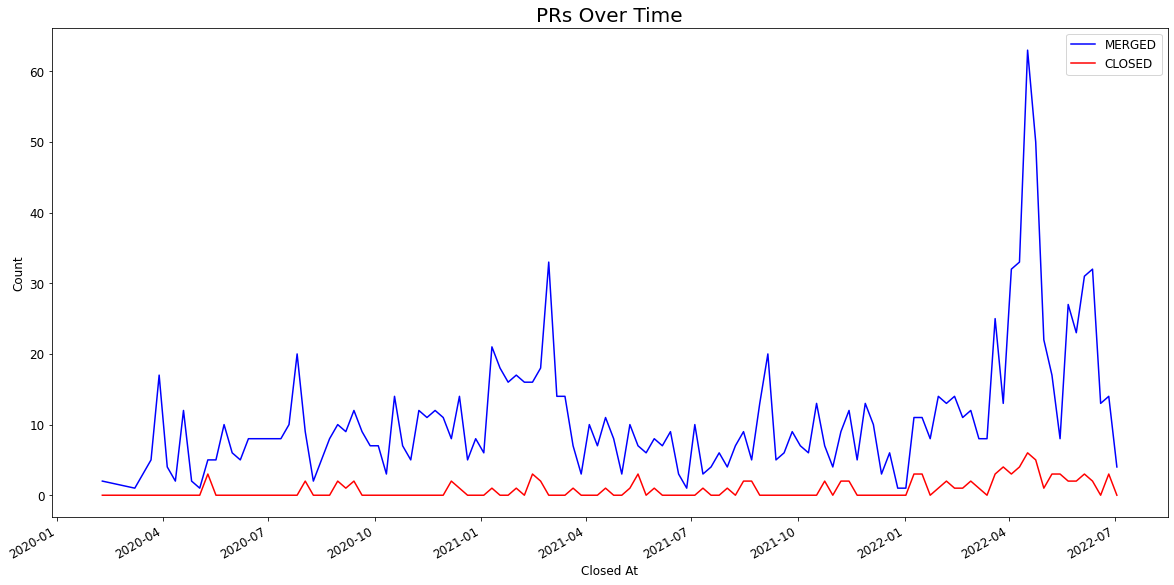

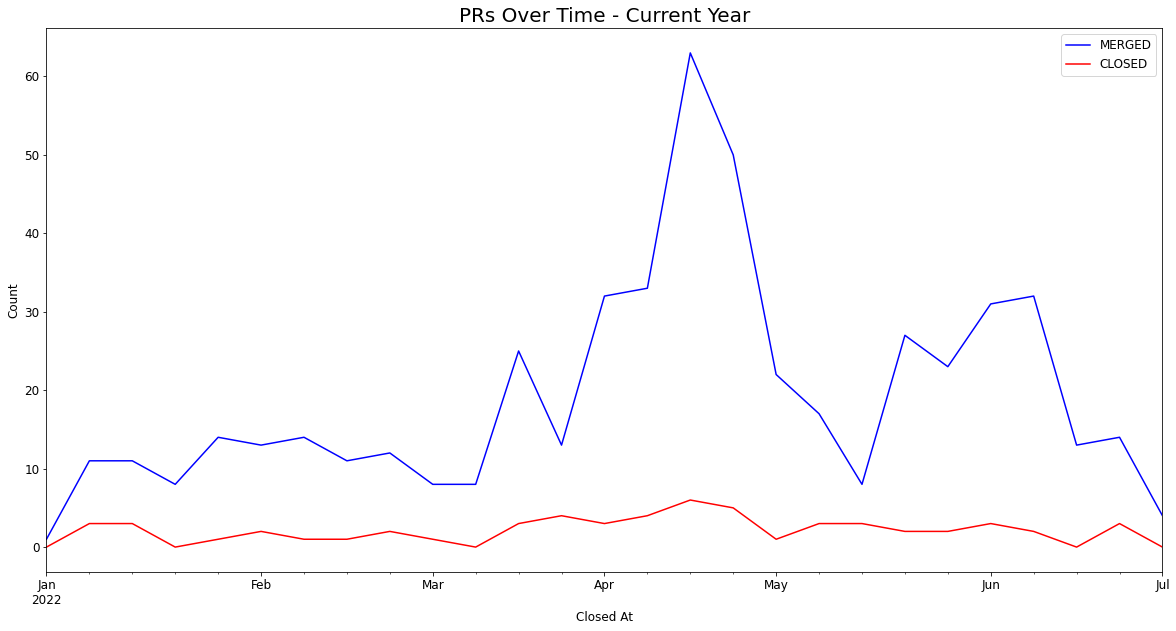

In [55]:
def zero_nan(df, col):
    return df[col].fillna(0)


# Count CLOSED/MERGED items per week
weekly_prs = prs.set_index('closedAt').groupby(
    [pd.Grouper(freq='W', label='left'), pd.Grouper('state')])['state'].count().reset_index(name='count')

# Pivot into column by state
weekly_prs_pivot = weekly_prs.pivot(
    index='closedAt', columns='state', values='count')

# Replace NaN
weekly_prs_pivot['CLOSED'] = zero_nan(weekly_prs_pivot, 'CLOSED')
weekly_prs_pivot['MERGED'] = zero_nan(weekly_prs_pivot, 'MERGED')

plt.figure(figsize=(20, 10), facecolor='white')
plt.title('PRs Over Time', fontsize=20)
weekly_prs_pivot['MERGED'].plot(color='blue',
                                label='MERGED', legend=True)
weekly_prs_pivot['CLOSED'].plot(color='red', label='CLOSED', legend=True)
plt.ylabel('Count')
plt.xlabel('Closed At')
plt.show()

# Filter to current year
weekly_prs_year = weekly_prs[weekly_prs['closedAt'].dt.year == date.today(
).year]

# Pivot into column by state
weekly_prs_pivot_year = weekly_prs_year.pivot(
    index='closedAt', columns='state', values='count')

# Replace NaN
weekly_prs_pivot_year['CLOSED'] = zero_nan(weekly_prs_pivot_year, 'CLOSED')
weekly_prs_pivot_year['MERGED'] = zero_nan(weekly_prs_pivot_year, 'MERGED')

plt.figure(figsize=(20, 10), facecolor='white')
plt.title('PRs Over Time - Current Year', fontsize=20)
weekly_prs_pivot_year['MERGED'].plot(color='blue',
                          label='MERGED', legend=True)
weekly_prs_pivot_year['CLOSED'].plot(color='red', label='CLOSED', legend=True)
plt.ylabel('Count')
plt.xlabel('Closed At')
plt.show()


### Total PRs Over Time

## Issues Over Time

### Bugs Opened & Closed Over Time

### Enhancements Closed Over Time